In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')
import sys 
import os
sys.path.append('/'.join(os.getcwd().split('/')[:4]))
from config.get import cfg
from tensorflow import keras
from tensorflow.keras import layers
import autoencoders

2022-01-09 14:41:48.072289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-09 14:41:48.072326: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Loaidng data

In [2]:
X_train = np.load(cfg['files']["raw_train_features"])
X_test  = np.load(cfg['files']["raw_test_features"])
print(f"shapes : X_train={X_train.shape},X_test={X_test.shape}")

shapes : X_train=(5354, 3, 600, 2),X_test=(1340, 3, 600, 2)


# Loading model

In [15]:
def CNN_fully_connected():
    model_name = "CNN_fully_connected"
    # build encoder
    # CNN
    input_img = keras.Input(shape=(3,600, 2))
    x = layers.Conv2D(8, (3, 3), activation='elu', padding='same')(input_img)
    x = layers.MaxPooling2D((3, 3), padding='same')(x)
    x = layers.Conv2D(4, (3, 3), activation='elu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(1, (2, 2), activation='elu', padding='same')(x)
    # Dense layers
    x = layers.Dense(100,  activation='elu')(x)
    encoded = layers.Dense(100,  activation='elu')(x)
    x = layers.Dense(100,  activation='elu')(encoded)
    x = layers.Dense(100,  activation='elu')(x)
    # build decoder
    x = layers.Conv2D(4, (2, 2), activation='elu', padding='same')(x)
    x = layers.UpSampling2D((1, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='elu', padding='same')(x)
    x = layers.UpSampling2D((3, 3))(x)
    decoded = layers.Conv2D(2, (3, 3), activation='elu', padding='same')(x)
    # combine encoder and decoder
    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error',)
    return model_name, autoencoder

In [16]:

model_name,autoencoder = CNN_fully_connected()
autoencoder.summary()
train_loss = []

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 600, 2)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 600, 8)         152       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 200, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 200, 4)         292       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 100, 4)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 1, 100, 1)         17  

In [ ]:
hist = autoencoder.fit(X_train, X_train,epochs=150)

Epoch 1/150
168/168 [==============================] - 30s 175ms/step - loss: 0.7484
Epoch 2/150
168/168 [==============================] - 30s 176ms/step - loss: 0.7072
Epoch 3/150
168/168 [==============================] - 30s 176ms/step - loss: 0.6966
Epoch 4/150
168/168 [==============================] - 30s 176ms/step - loss: 0.6919
Epoch 5/150
168/168 [==============================] - 29s 175ms/step - loss: 0.6884
Epoch 6/150
168/168 [==============================] - 29s 174ms/step - loss: 0.6849
Epoch 7/150
168/168 [==============================] - 30s 176ms/step - loss: 0.6818
Epoch 8/150
168/168 [==============================] - 30s 176ms/step - loss: 0.6786
Epoch 9/150
168/168 [==============================] - 29s 175ms/step - loss: 0.6761
Epoch 10/150
168/168 [==============================] - 30s 181ms/step - loss: 0.6731
Epoch 11/150
168/168 [==============================] - 30s 180ms/step - loss: 0.6703
Epoch 12/150
168/168 [==============================] - 29s 175

In [5]:
train_loss+=hist.history["loss"]

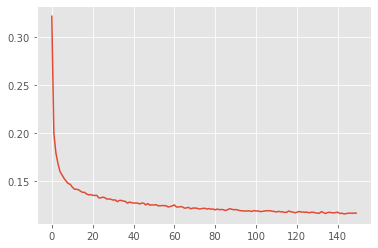

In [6]:
plt.plot(train_loss)
plt.show()

# Saving 

In [8]:
autoencoder.save(cfg["models"]["autoencoder"] + f"{model_name}")

In [10]:
np.save(file = cfg["models"]["autoencoder"]+ f"{model_name}_train_loss", arr = np.array(train_loss))

# testing 

In [31]:
def mean_squared_error(x,y):
    return np.sum((x-y)**2)/x.size

train_pred = autoencoder(X_train).numpy()
test_pred  = autoencoder(X_test).numpy()

print(f"MSE train : {mean_squared_error(train_pred,X_train)} \nMSE test  : {mean_squared_error(test_pred,X_test)}")

MSE train : 0.6656895960779817 
MSE test  : 0.672439797862461
